<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indexes/blob/main/Code/XGBoost_Regressor_with_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product
import statsmodels.api as sm
import shap
from IPython.display import display
import math

In [2]:
import warnings
warnings.filterwarnings("ignore")

# **XGBOOST REGRESSOR**

**First, we plot the ACF for every feature to determine the amount of lags needed and the interval between them, since the granularity is 1 sec.**

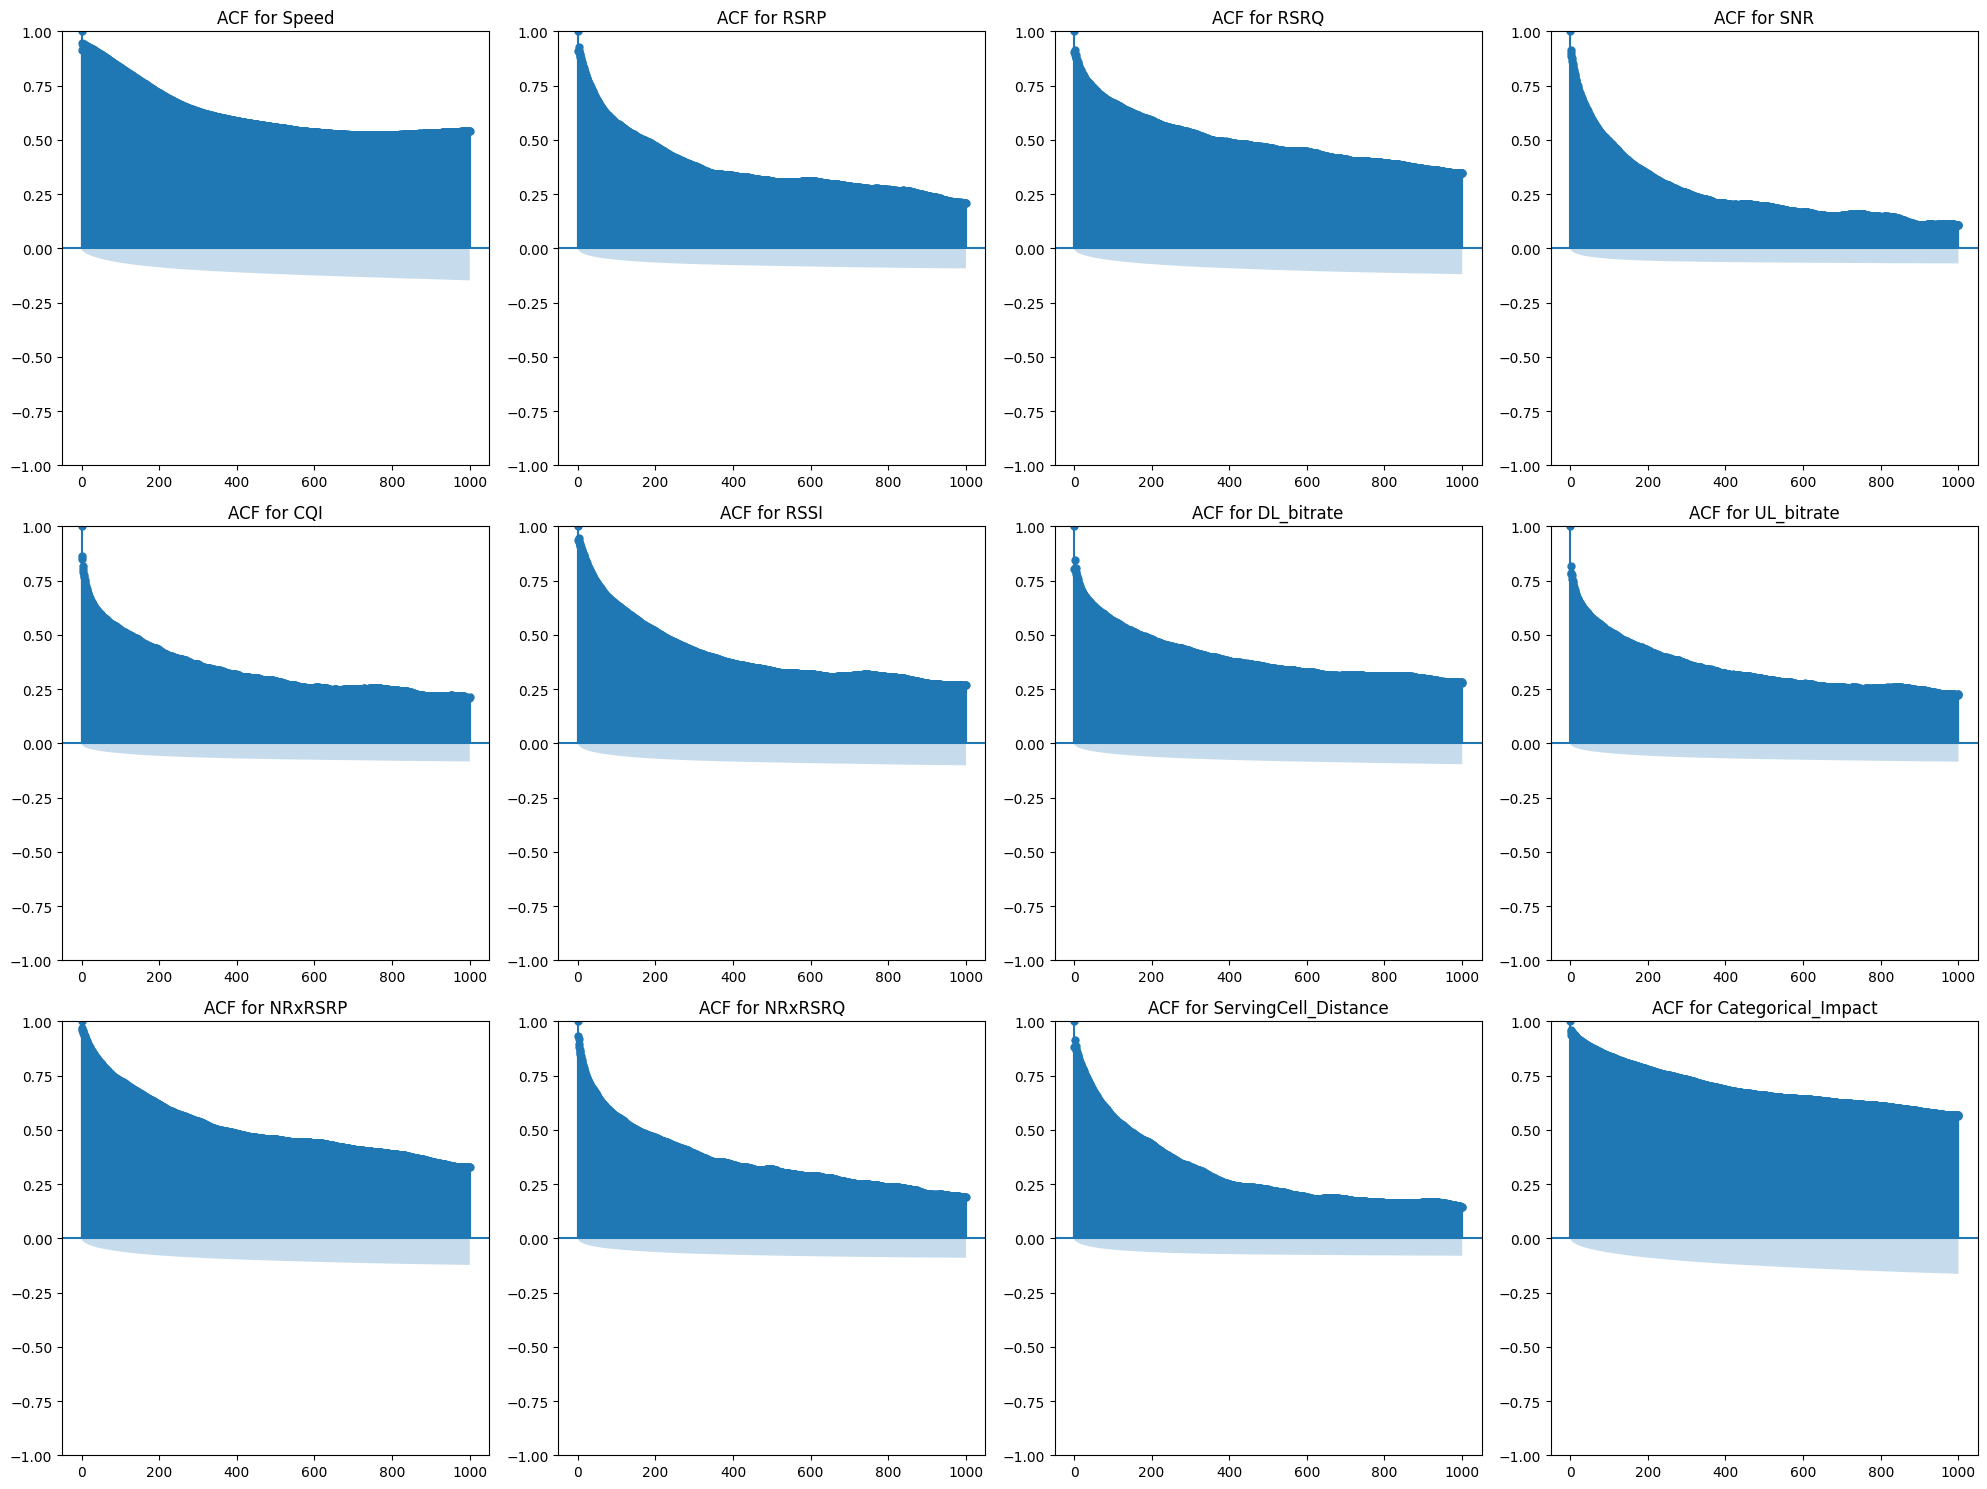

In [3]:
# Load the final dataset
df = pd.read_csv("/content/drive/MyDrive/training_set.csv")

# Select all numerical features to analyze
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# Compute and plot the Autocorrelation Function (ACF) for each numerical feature
rows, cols = 3, 4
num_features = len(features)
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, column in enumerate(features):
    row, col = divmod(i, cols)
    sm.graphics.tsa.plot_acf(
        df[column].dropna(), lags=1000, alpha=0.05, ax=axes[row, col]
    )
    axes[row, col].set_title(f"ACF for {column}")

plt.tight_layout()
plt.show()


**Then, we apply Grid Search in the train set with 5-Cross Validation to determine the best combination of the hyperparameters for the different amount of lagged features based on MAE of Validation Set. We split the train set into the following subsets:**

**Training Set: 60%**

**Validation Set: 20%**



**We also apply Min-Max Normalization since the numeric features are measured in different units.**

In [ ]:
# --- Δημιουργία lagged χαρακτηριστικών
def create_lagged_features(df, features, num_lags, lag_interval=1):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    return df.dropna()

# --- Ορισμός χαρακτηριστικών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# --- Παράμετροι
lag_interval = 60
num_lags_list = [5, 10, 20, 30]
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.05, 0.1, 1]
}
param_combinations = list(product(param_grid["n_estimators"],
                                  param_grid["max_depth"],
                                  param_grid["learning_rate"]))

results_list = []

for num_lags in num_lags_list:
    df_lagged = create_lagged_features(df, features, num_lags, lag_interval=lag_interval)

    X = df_lagged.drop(columns=["Timestamp", "DL_bitrate"])
    y = df_lagged["DL_bitrate"]

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    for n_estimators, max_depth, learning_rate in param_combinations:
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            objective="reg:squarederror",
            random_state=42
        )

        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
        y_val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

        mae_val = mean_absolute_error(y_val_true, y_val_pred_denorm)

        results_list.append({
            "num_lags": num_lags,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "MAE_Validation": mae_val
        })

# --- Εύρεση καλύτερου συνδυασμού
results_df = pd.DataFrame(results_list)
best_row = results_df.loc[results_df["MAE_Validation"].idxmin()]

print("\n--- Best Configuration Based on Validation MAE ---")
print(f"Num Lags      : {best_row['num_lags']}")
print(f"n_estimators  : {best_row['n_estimators']}")
print(f"max_depth     : {int(best_row['max_depth'])}")
print(f"learning_rate : {best_row['learning_rate']}")
print(f"Validation MAE: {best_row['MAE_Validation']:.2f}")


--- Best Configuration Based on Validation MAE ---
Num Lags      : 30.0
n_estimators  : 200.0
max_depth     : 3
learning_rate : 0.05
Validation MAE: 876.59


**We train the model using the best combination of lags and hyperparameters and use the test set for the evaluation of the predictions. We also apply Feature Engineering to add rolling window statistic and time based features as input features to boost the performance of the model.**

In [6]:
# Load train and test datasets
df_train = pd.read_csv("/content/drive/MyDrive/training_set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_set.csv")

# List of numerical features to process
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# Parameters
best_num_lags = 30  # Optimal number of lags (determined previously)
rolling_features = ['RSRP', 'RSRQ', 'SNR', 'RSSI', 'Speed', 'DL_bitrate', 'UL_bitrate']
apply_log_to = ['DL_bitrate', 'UL_bitrate']
rolling_windows = [10, 30]  # In minutes

def preprocess(df):
    """Preprocess the given DataFrame: lag features, time-based features, rolling stats, log transform."""
    df_lagged = create_lagged_features(df, features, best_num_lags, lag_interval=60)

    # Convert timestamp to datetime and extract time-based features
    df_lagged["Timestamp"] = pd.to_datetime(df_lagged["Timestamp"])
    df_lagged["Hour"] = df_lagged["Timestamp"].dt.hour
    df_lagged["Day_of_week"] = df_lagged["Timestamp"].dt.dayofweek
    df_lagged["Is_weekend"] = df_lagged["Day_of_week"].isin([5, 6]).astype(int)

    # Compute rolling mean features
    for feature in rolling_features:
        for window in rolling_windows:
            df_lagged[f"{feature}_roll_mean_{window}"] = df_lagged[feature].rolling(window=window).mean()

    # Drop rows with NaNs introduced by rolling or lagging
    df_lagged.dropna(inplace=True)

    # Apply log1p transformation to selected features
    for col in apply_log_to:
        df_lagged[col] = np.log1p(df_lagged[col])

    return df_lagged

# Apply the same preprocessing pipeline to both train and test sets
df_train_processed = preprocess(df_train)
df_test_processed = preprocess(df_test)



In [7]:
df_train_processed

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,...,SNR_roll_mean_10,SNR_roll_mean_30,RSSI_roll_mean_10,RSSI_roll_mean_30,Speed_roll_mean_10,Speed_roll_mean_30,DL_bitrate_roll_mean_10,DL_bitrate_roll_mean_30,UL_bitrate_roll_mean_10,UL_bitrate_roll_mean_30
1829,2017-11-21 15:40:02,3.0,-76.0,-13.0,12.0,8.0,-58.0,7.312553,3.951244,-79.0,...,11.6,1.533333,-58.8,-58.866667,0.9,2.200000,5121.8,3856.800000,109.4,80.666667
1830,2017-11-21 15:40:04,3.0,-74.0,-13.0,10.0,8.0,-58.0,8.192294,4.543295,-85.0,...,12.3,1.966667,-58.9,-58.833333,1.2,2.200000,4701.3,3957.100000,104.4,83.400000
1831,2017-11-21 15:40:05,3.0,-74.0,-13.0,10.0,8.0,-58.0,8.539346,4.564348,-85.0,...,12.0,2.400000,-58.8,-58.800000,1.5,2.200000,5019.0,4107.366667,109.1,86.200000
1832,2017-11-21 15:40:06,3.0,-77.0,-13.0,15.0,11.0,-60.0,7.377759,3.401197,-85.0,...,12.2,3.000000,-58.7,-58.833333,1.8,2.200000,4552.6,4124.533333,100.4,86.366667
1833,2017-11-21 15:40:07,4.0,-77.0,-13.0,15.0,11.0,-60.0,7.377759,3.401197,-85.0,...,12.5,3.700000,-58.9,-58.866667,2.2,2.233333,4001.2,4117.466667,85.2,85.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138948,2018-01-18 15:03:26,0.0,-95.0,-14.0,-5.0,8.0,-88.0,8.826441,4.644391,-98.0,...,-4.3,-4.133333,-88.0,-87.150000,18.4,23.000000,10105.6,9684.233333,155.4,159.666667
138949,2018-01-18 15:03:26,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.570669,5.379897,-107.0,...,-4.1,-4.033333,-88.0,-87.150000,23.0,23.000000,10995.8,9843.766667,168.1,161.866667
138950,2018-01-18 15:03:27,0.0,-95.0,-14.0,-5.0,8.0,-88.0,9.041211,4.962845,-98.0,...,-4.3,-4.033333,-88.0,-87.450000,18.4,23.000000,10663.6,9942.933333,165.4,163.733333
138951,2018-01-18 15:03:28,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.640758,5.549076,-107.0,...,-3.9,-3.933333,-88.0,-87.450000,23.0,23.000000,11593.0,9995.133333,178.6,164.933333


In [8]:
df_test_processed

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,...,SNR_roll_mean_10,SNR_roll_mean_30,RSSI_roll_mean_10,RSSI_roll_mean_30,Speed_roll_mean_10,Speed_roll_mean_30,DL_bitrate_roll_mean_10,DL_bitrate_roll_mean_30,UL_bitrate_roll_mean_10,UL_bitrate_roll_mean_30
1829,2018-01-18 15:20:12,55,-103,-13.0,6.0,7.0,-85.5,9.593083,5.476464,-109.0,...,8.0,9.233333,-81.25,-80.200000,27.5,27.500000,30329.4,31936.600000,359.1,372.100000
1830,2018-01-18 15:20:12,0,-95,-11.0,9.0,8.0,-85.0,10.128270,5.799093,-109.0,...,8.2,9.500000,-81.95,-80.566667,27.5,27.500000,28437.0,32376.100000,341.4,376.533333
1831,2018-01-18 15:20:13,0,-105,-14.0,3.0,6.0,-88.0,10.014403,5.669881,-106.0,...,7.4,9.566667,-82.55,-80.983333,22.0,27.500000,28473.9,32269.466667,337.9,375.633333
1832,2018-01-18 15:20:13,55,-104,-13.0,5.0,7.0,-88.0,9.662307,5.416100,-107.0,...,7.2,9.200000,-83.85,-81.350000,27.5,27.500000,25846.8,31041.100000,315.2,364.100000
1833,2018-01-18 15:20:14,55,-104,-13.0,5.0,7.0,-88.0,9.812687,5.564520,-107.0,...,6.9,9.233333,-84.85,-81.683333,33.0,29.333333,24683.7,30838.300000,307.3,363.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34734,2018-02-12 16:28:41,0,-104,-11.0,13.0,10.0,-83.0,10.611203,6.628041,-90.0,...,8.4,11.400000,-83.55,-78.516667,0.0,0.000000,20701.1,24708.366667,371.3,577.300000
34735,2018-02-12 16:28:42,0,-106,-13.0,3.0,7.0,-90.0,8.411166,4.382027,-90.0,...,8.0,10.900000,-84.95,-78.983333,0.0,0.000000,20502.1,23209.733333,368.8,536.566667
34736,2018-02-12 16:28:42,0,-104,-11.0,13.0,10.0,-83.0,10.802042,6.813445,-90.0,...,7.6,11.100000,-85.45,-79.216667,0.0,0.000000,20440.6,24790.433333,369.5,565.833333
34737,2018-02-12 16:28:43,0,-100,-12.0,16.0,13.0,-81.0,10.991460,7.085901,-90.0,...,8.5,11.033333,-85.95,-79.383333,0.0,0.000000,26108.6,24799.000000,483.7,562.266667


**To check if the model is over or under fitting we plot the learning curves for the training, validation and testing set.**

[0]	train-rmse:0.29681	train-mae:0.22239	eval-rmse:0.22709	eval-mae:0.19844	test-rmse:0.23784	test-mae:0.18931
[10]	train-rmse:0.18263	train-mae:0.13789	eval-rmse:0.14770	eval-mae:0.12977	test-rmse:0.15414	test-mae:0.12221
[20]	train-rmse:0.11493	train-mae:0.08782	eval-rmse:0.09840	eval-mae:0.08598	test-rmse:0.10479	test-mae:0.08148
[30]	train-rmse:0.07591	train-mae:0.05878	eval-rmse:0.06931	eval-mae:0.05972	test-rmse:0.07770	test-mae:0.05833
[40]	train-rmse:0.05445	train-mae:0.04193	eval-rmse:0.05283	eval-mae:0.04415	test-rmse:0.06365	test-mae:0.04526
[50]	train-rmse:0.04364	train-mae:0.03229	eval-rmse:0.04387	eval-mae:0.03511	test-rmse:0.05685	test-mae:0.03832
[60]	train-rmse:0.03857	train-mae:0.02679	eval-rmse:0.03901	eval-mae:0.02980	test-rmse:0.05337	test-mae:0.03457
[70]	train-rmse:0.03630	train-mae:0.02367	eval-rmse:0.03661	eval-mae:0.02701	test-rmse:0.05170	test-mae:0.03255
[80]	train-rmse:0.03524	train-mae:0.02185	eval-rmse:0.03531	eval-mae:0.02533	test-rmse:0.05072	test-mae:0

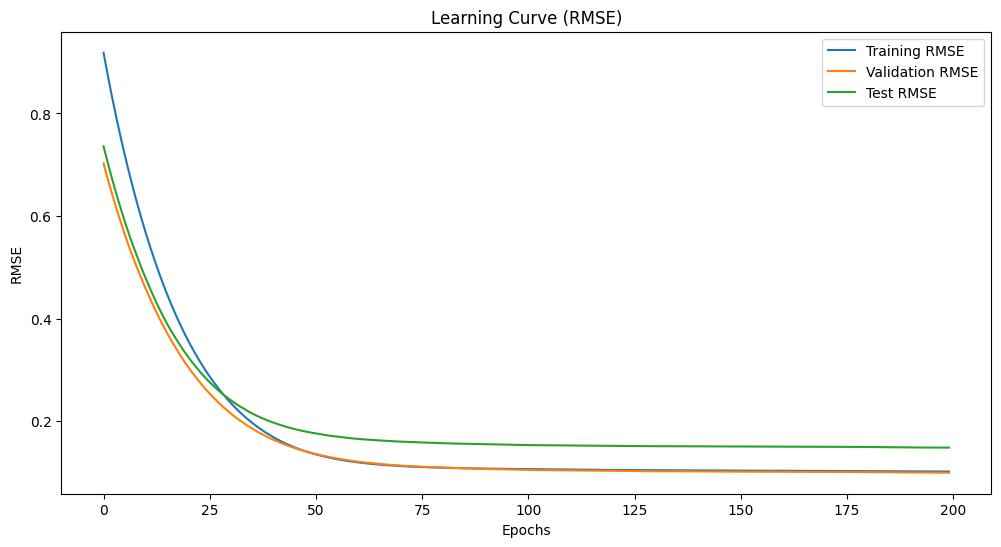

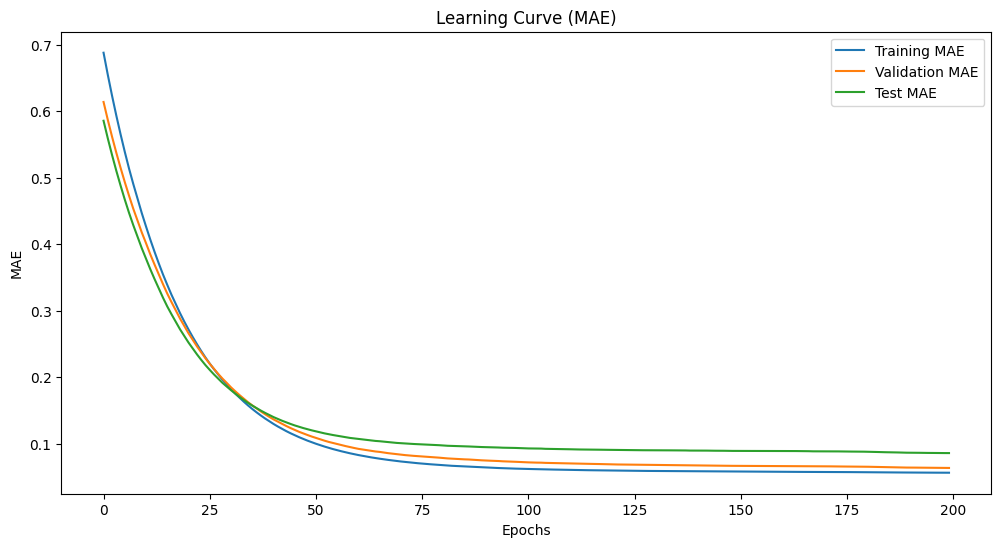

----------------------------------------
Train RMSE: 1685.31
Train MAE : 934.29
----------------------------------------
Validation RMSE: 4272.07
Validation MAE : 2687.17
----------------------------------------
Test RMSE: 6837.28
Test MAE : 3019.11


In [9]:

# Separate features and target for training set
X_train_full = df_train_processed.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_train_full = df_train_processed["DL_bitrate"]

#  Normalize both features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_full_scaled = scaler_X.fit_transform(X_train_full)
y_train_full_scaled = scaler_y.fit_transform(y_train_full.values.reshape(-1, 1)).flatten()

#  Split train set into train (80%) and validation (20%) without shuffling
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_scaled, y_train_full_scaled, test_size=0.2, random_state=42, shuffle=False
)

#  Prepare the test set
X_test = df_test_processed.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_test = df_test_processed["DL_bitrate"]
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

#  Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled)

#  Define model hyperparameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'eval_metric': ['rmse', 'mae']
}

evals = [(dtrain, 'train'), (dval, 'eval'), (dtest, 'test')]
num_round = 200
history = dict()

#  Train the XGBoost model with early stopping
bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10,
                verbose_eval=10, evals_result=history)

#  Extract and plot learning curves
epochs = len(history['train']['rmse'])
train_rmse = np.array(history['train']['rmse']) * np.std(y_train_full)
eval_rmse = np.array(history['eval']['rmse']) * np.std(y_train_full)
test_rmse = np.array(history['test']['rmse']) * np.std(y_train_full)

train_mae = np.array(history['train']['mae']) * np.std(y_train_full)
eval_mae = np.array(history['eval']['mae']) * np.std(y_train_full)
test_mae = np.array(history['test']['mae']) * np.std(y_train_full)

plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_rmse, label="Training RMSE")
plt.plot(range(epochs), eval_rmse, label="Validation RMSE")
plt.plot(range(epochs), test_rmse, label="Test RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_mae, label="Training MAE")
plt.plot(range(epochs), eval_mae, label="Validation MAE")
plt.plot(range(epochs), test_mae, label="Test MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Learning Curve (MAE)")
plt.legend()
plt.show()

#  Make predictions and inverse-transform them
def inverse_transform_predictions(y_true_scaled, y_pred_scaled, scaler):
    y_true = np.expm1(scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten())
    y_pred = np.expm1(scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten())
    return y_true, y_pred

y_train_pred = bst.predict(dtrain)
y_val_pred = bst.predict(dval)
y_test_pred = bst.predict(dtest)

y_train_true, y_train_pred_denorm = inverse_transform_predictions(y_train, y_train_pred, scaler_y)
y_val_true, y_val_pred_denorm = inverse_transform_predictions(y_val, y_val_pred, scaler_y)
y_test_true, y_test_pred_denorm = inverse_transform_predictions(y_test_scaled, y_test_pred, scaler_y)

#  Combine predictions into a single DataFrame
predictions_df = pd.concat([
    pd.DataFrame({"true": y_train_true, "pred": y_train_pred_denorm, "set": "train"}),
    pd.DataFrame({"true": y_val_true, "pred": y_val_pred_denorm, "set": "val"}),
    pd.DataFrame({"true": y_test_true, "pred": y_test_pred_denorm, "set": "test"})
], ignore_index=True)

#  Define evaluation function
def print_metrics(name, true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print("-" * 40)
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} MAE : {mae:.2f}")

# \ Print final metrics
print_metrics("Train", y_train_true, y_train_pred_denorm)
print_metrics("Validation", y_val_true, y_val_pred_denorm)
print_metrics("Test", y_test_true, y_test_pred_denorm)


**We calculate for better understanding the percentages of the error metrics to see how far the predictions are from the average actual DL_bitrate of the test data.**

In [18]:
# Φιλτράρισμα test set από το predictions_df
test_data = predictions_df[predictions_df["set"] == "test"]

# Υπολογισμός μέσης πραγματικής τιμής
mean_actual_value = test_data["true"].mean()

# Υπολογισμός MAE & RMSE από το predictions_df
test_mae = mean_absolute_error(test_data["true"], test_data["pred"])

print(f"Mean actual DL_bitrate in test set: {mean_actual_value:.2f} Kbps")

# Εκτύπωση ποσοστών σφάλματος ως προς τη μέση τιμή
print(f"Percentage of MAE: {(test_mae / mean_actual_value) * 100:.2f}%")


Mean actual DL_bitrate in test set: 11951.01 Kbps
Percentage of MAE: 25.26%


**After the evaluation of the model we plot the actual and the predicted timeseries to visualize the forecasting results.**

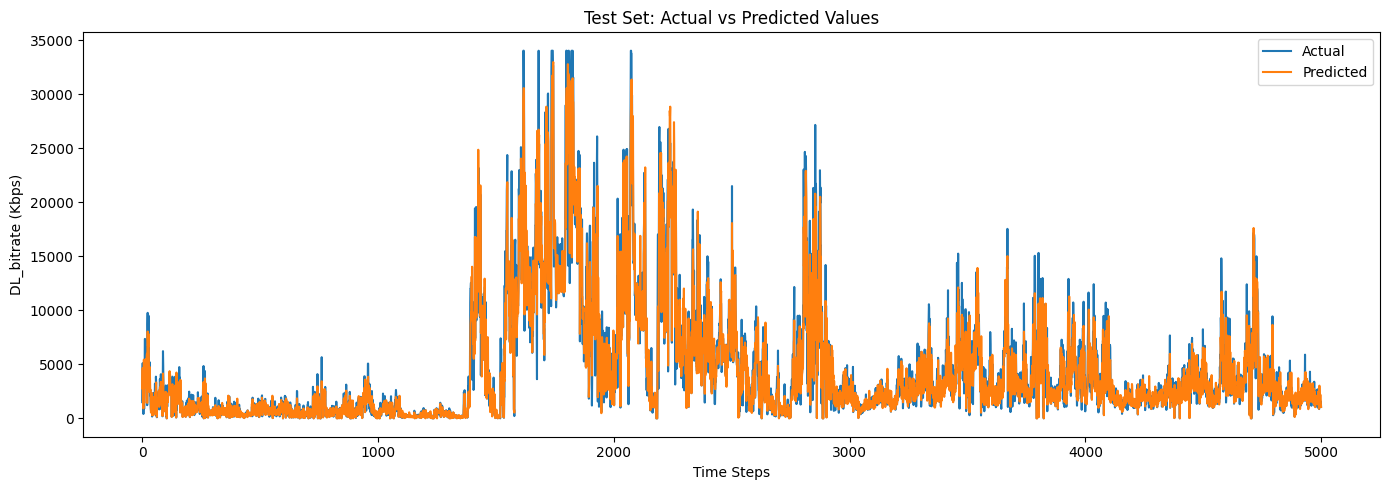

In [12]:
# === Timeseries Actual vs Predicted (Test Set)
plt.figure(figsize=(14, 5))
plt.plot(predictions_df["true"].values[:5000], label='Actual')
plt.plot(predictions_df["pred"].values[:5000], label='Predicted')
plt.title("Test Set: Actual vs Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate (Kbps)")
plt.legend()
plt.tight_layout()
plt.show()

**Finally, we use the SHAP tool to determine which features contribute the most into the final forecasting value. We compute a Waterfall Plot to check the feature contribution in one instance and then we compute Bar Plot and Beeswarm Plot to determine the overall contribution.**

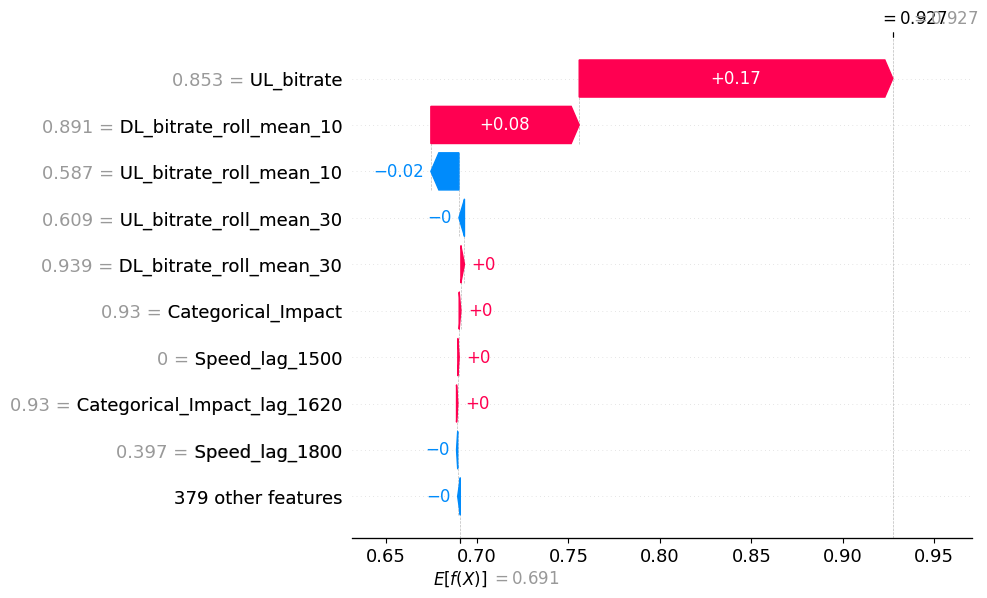

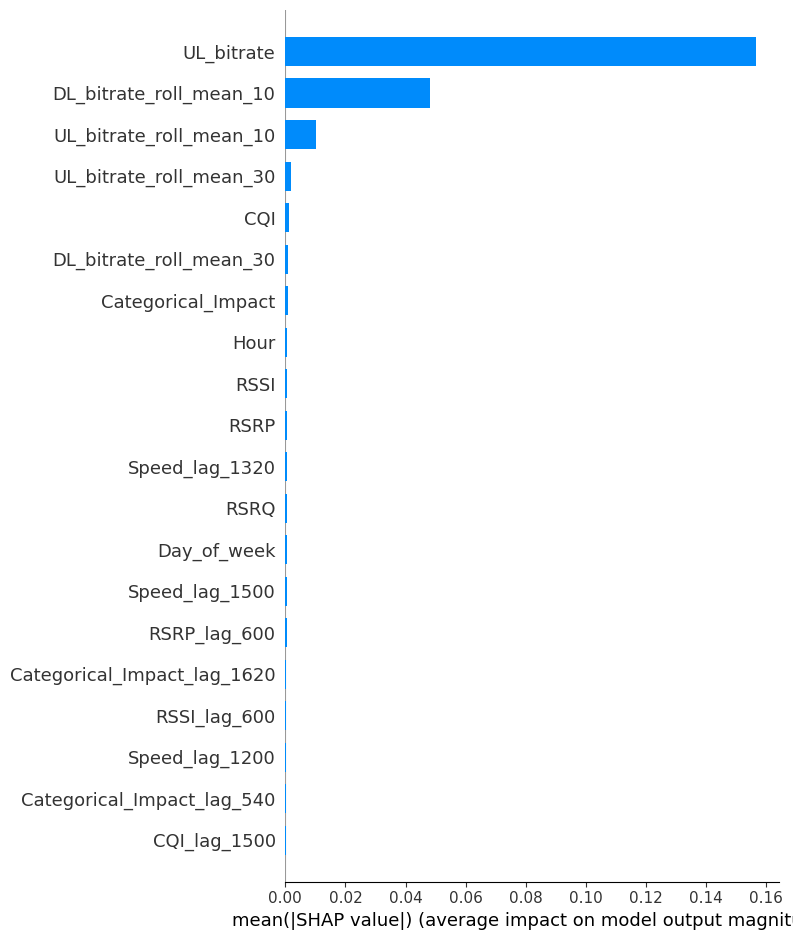

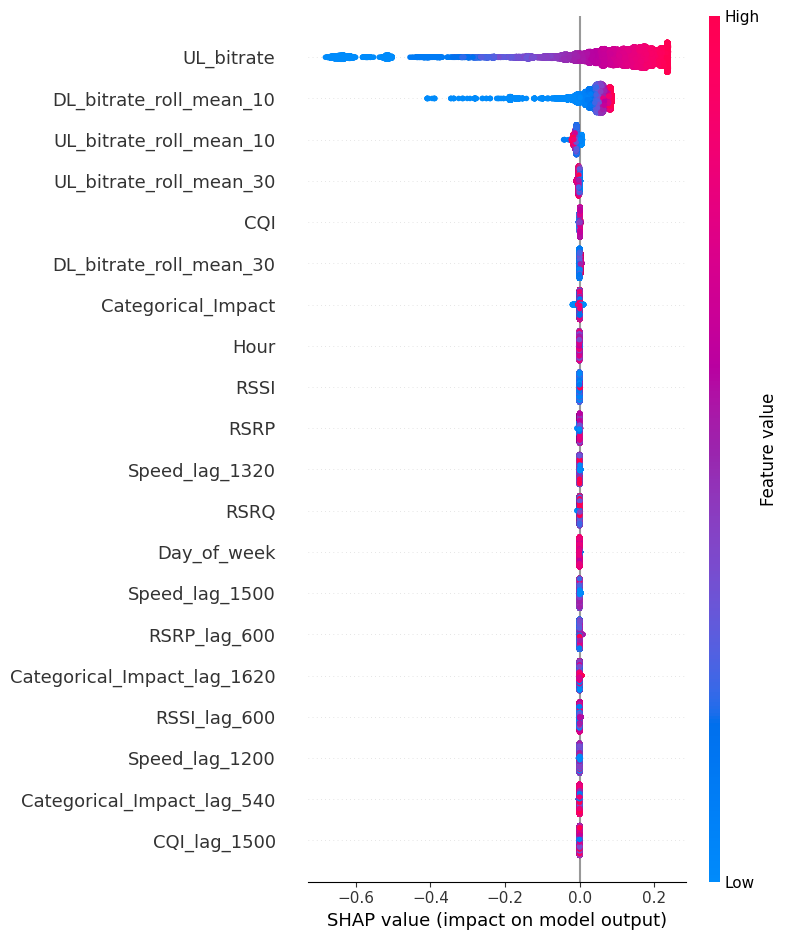

In [21]:
import shap

# Create DataFrame with the same feature names used in training
X_test_df = pd.DataFrame(X_test_scaled, columns=X_train_full.columns)

# Initialize SHAP for Tree-based models
explainer = shap.TreeExplainer(bst)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# --- SHAP Plots ---

# Waterfall plot for the first instance
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0],
                                      base_values=explainer.expected_value,
                                      data=X_test_df.iloc[0],
                                      feature_names=X_test_df.columns))

# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# Beeswarm plot
shap.summary_plot(shap_values, X_test_df)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


#  Define target and drop columns
target_col = "DL_bitrate"
drop_cols = ["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"]

X_full = df_train_processed.drop(columns=drop_cols, errors="ignore")
y_full = df_train_processed[target_col]
X_test_full = df_test_processed.drop(columns=drop_cols, errors="ignore")
y_test_full = df_test_processed[target_col]
feature_names = X_full.columns

# === Normalize (fit only on training set)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_full)
y_scaled = scaler_y.fit_transform(y_full.values.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test_full)
y_test_scaled = scaler_y.transform(y_test_full.values.reshape(-1, 1)).flatten()

# === Train/Validation split (80/20) - no shuffle
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42
)

# === Train initial model for SHAP
dtrain = xgb.DMatrix(X_train, label=y_train)
bst = xgb.train(
    params={
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.1,
        "eval_metric": "rmse"
    },
    dtrain=dtrain,
    num_boost_round=200
)

#  Compute SHAP values on the test set
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test_df)

#  Rank features by SHAP importance
shap_df = pd.DataFrame(shap_values, columns=feature_names)
shap_importance = shap_df.abs().mean().sort_values(ascending=False)
ordered_features = shap_importance.index.tolist()

#  Retrain with top-N SHAP features
results = []
step = 10

for num_feats in range(len(ordered_features), step - 1, -step):
    top_features = ordered_features[:num_feats]
    X_subset = df_train_processed[top_features]
    y = df_train_processed[target_col]
    X_test_subset = df_test_processed[top_features]
    y_test = df_test_processed[target_col]

    # Normalize with MinMaxScaler
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_subset)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
    X_test_scaled = scaler_X.transform(X_test_subset)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # Train/val split again on reduced features
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42
    )

    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict and inverse transform
    y_pred = model.predict(X_test_scaled)
    y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_denorm = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

    results.append({
        "Num_Features": num_feats,
        "RMSE": rmse,
        "MAE": mae
    })

# === Plotting results
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df["Num_Features"], results_df["RMSE"], marker='o', label="RMSE")
plt.plot(results_df["Num_Features"], results_df["MAE"], marker='s', label="MAE")
plt.xlabel("Number of Top SHAP Features")
plt.ylabel("Error (Mbps)")
plt.title("XGBoost Performance vs SHAP Feature Count")
plt.legend()
plt.gca().invert_xaxis()
plt.show()


KeyError: "['DL_bitrate_roll_mean_10', 'UL_bitrate_roll_mean_10', 'UL_bitrate_roll_mean_30', 'DL_bitrate_roll_mean_30', 'Speed_lag_420', 'Hour', 'Speed_lag_840', 'RSRP_roll_mean_30', 'Speed_lag_1560', 'RSRP_roll_mean_10', 'RSRQ_roll_mean_30', 'UL_bitrate_lag_1320', 'DL_bitrate_lag_1320', 'Speed_roll_mean_30', 'RSRP_lag_600', 'Speed_lag_1140', 'RSSI_roll_mean_10', 'RSRP_lag_1080', 'Speed_lag_780', 'SNR_roll_mean_10', 'RSSI_lag_600', 'Speed_lag_1200', 'Day_of_week', 'Categorical_Impact_lag_360', 'CQI_lag_1680', 'Speed_lag_1440', 'Speed_lag_1320', 'Speed_lag_1620', 'Speed_lag_120', 'Speed_lag_900', 'Speed_lag_1260', 'DL_bitrate_lag_1620', 'Speed_lag_1500', 'Speed_lag_1380', 'Categorical_Impact_lag_1620', 'RSRP_lag_480', 'RSRP_lag_540', 'RSRQ_roll_mean_10', 'SNR_lag_120', 'RSSI_lag_660', 'Speed_lag_480', 'Categorical_Impact_lag_1140', 'Categorical_Impact_lag_1800', 'CQI_lag_1500', 'NRxRSRP_lag_960', 'RSRP_lag_1320', 'SNR_lag_1500', 'ServingCell_Distance_lag_840', 'DL_bitrate_lag_1740', 'Categorical_Impact_lag_1740', 'NRxRSRQ_lag_1380', 'ServingCell_Distance_lag_900', 'UL_bitrate_lag_120', 'RSRP_lag_1200', 'Categorical_Impact_lag_240', 'DL_bitrate_lag_240', 'Speed_lag_1800', 'Speed_lag_180', 'RSRP_lag_720', 'NRxRSRQ_lag_780', 'Speed_lag_960', 'RSRP_lag_900', 'DL_bitrate_lag_1500', 'ServingCell_Distance_lag_1020', 'DL_bitrate_lag_1560', 'RSSI_lag_60', 'RSRP_lag_660', 'DL_bitrate_lag_60', 'NRxRSRQ_lag_1440', 'DL_bitrate_lag_480', 'Categorical_Impact_lag_960', 'Categorical_Impact_lag_60', 'RSRP_lag_780', 'NRxRSRP_lag_780', 'ServingCell_Distance_lag_1080', 'RSSI_lag_540', 'SNR_lag_180', 'RSSI_roll_mean_30', 'CQI_lag_1080', 'Speed_lag_240', 'NRxRSRQ_lag_1260', 'NRxRSRQ_lag_540', 'UL_bitrate_lag_480', 'SNR_lag_720', 'DL_bitrate_lag_1440', 'UL_bitrate_lag_60', 'Speed_lag_300', 'Speed_lag_1680', 'Speed_lag_1080', 'Speed_lag_360', 'ServingCell_Distance_lag_600', 'UL_bitrate_lag_420', 'Categorical_Impact_lag_120', 'UL_bitrate_lag_960', 'NRxRSRP_lag_1500', 'DL_bitrate_lag_1200', 'UL_bitrate_lag_1620', 'RSRP_lag_1500', 'NRxRSRP_lag_1560', 'Categorical_Impact_lag_1080', 'NRxRSRQ_lag_1140', 'SNR_lag_1800', 'Categorical_Impact_lag_1260', 'Categorical_Impact_lag_600', 'RSSI_lag_1140', 'RSRP_lag_120', 'NRxRSRQ_lag_360', 'NRxRSRQ_lag_960', 'NRxRSRP_lag_540', 'RSSI_lag_720', 'NRxRSRQ_lag_1500', 'DL_bitrate_lag_780', 'DL_bitrate_lag_600', 'ServingCell_Distance_lag_1140', 'RSRP_lag_420', 'RSRP_lag_360', 'CQI_lag_420', 'RSRP_lag_1440', 'ServingCell_Distance_lag_240', 'RSRP_lag_1620', 'Categorical_Impact_lag_180', 'RSRQ_lag_120', 'RSRP_lag_1260', 'RSSI_lag_180', 'NRxRSRQ_lag_1080', 'UL_bitrate_lag_1500', 'SNR_roll_mean_30', 'ServingCell_Distance_lag_1680', 'DL_bitrate_lag_1260', 'Speed_lag_660', 'SNR_lag_60', 'NRxRSRQ_lag_900', 'SNR_lag_780', 'RSSI_lag_1380', 'SNR_lag_1200', 'DL_bitrate_lag_900', 'ServingCell_Distance_lag_1620', 'Speed_lag_1020', 'DL_bitrate_lag_1680', 'RSRP_lag_1680', 'SNR_lag_240', 'SNR_lag_960', 'RSRP_lag_60', 'NRxRSRQ_lag_840', 'RSRQ_lag_1440', 'ServingCell_Distance_lag_1740', 'Speed_roll_mean_10', 'CQI_lag_1200', 'SNR_lag_1140', 'SNR_lag_900', 'RSRP_lag_240', 'RSSI_lag_300', 'NRxRSRP_lag_1140', 'RSRQ_lag_360', 'ServingCell_Distance_lag_960', 'SNR_lag_300', 'Speed_lag_60', 'DL_bitrate_lag_420', 'ServingCell_Distance_lag_1800', 'RSRP_lag_1740', 'RSRQ_lag_1620', 'RSRP_lag_1140', 'NRxRSRP_lag_120', 'UL_bitrate_lag_1200', 'SNR_lag_840', 'NRxRSRP_lag_1380', 'RSRP_lag_300', 'ServingCell_Distance_lag_1200', 'SNR_lag_600', 'DL_bitrate_lag_1080', 'NRxRSRP_lag_600', 'SNR_lag_360', 'DL_bitrate_lag_120', 'Speed_lag_1740', 'Categorical_Impact_lag_1380', 'RSRP_lag_180', 'DL_bitrate_lag_840', 'NRxRSRQ_lag_480', 'RSSI_lag_1500', 'SNR_lag_1560', 'SNR_lag_1440', 'RSSI_lag_1620', 'DL_bitrate_lag_1800', 'CQI_lag_720', 'RSRP_lag_1020', 'Categorical_Impact_lag_1320', 'ServingCell_Distance_lag_1440', 'SNR_lag_420', 'RSRQ_lag_180', 'NRxRSRQ_lag_1800', 'DL_bitrate_lag_540', 'RSRP_lag_1800', 'UL_bitrate_lag_300', 'ServingCell_Distance_lag_1380', 'NRxRSRQ_lag_1200', 'RSSI_lag_1320', 'NRxRSRP_lag_1260', 'DL_bitrate_lag_720', 'SNR_lag_1740', 'CQI_lag_600', 'SNR_lag_1320', 'NRxRSRP_lag_1740', 'SNR_lag_1080', 'RSRP_lag_1380', 'UL_bitrate_lag_1140', 'CQI_lag_240', 'CQI_lag_1620', 'RSRQ_lag_1500', 'NRxRSRP_lag_1320', 'Categorical_Impact_lag_540', 'RSSI_lag_1260', 'UL_bitrate_lag_1260', 'RSSI_lag_240', 'DL_bitrate_lag_1140', 'Categorical_Impact_lag_1440', 'Categorical_Impact_lag_1500', 'RSSI_lag_480', 'NRxRSRP_lag_360', 'NRxRSRP_lag_1620', 'UL_bitrate_lag_1020', 'UL_bitrate_lag_1380', 'ServingCell_Distance_lag_1320', 'RSRP_lag_960', 'RSSI_lag_120', 'NRxRSRQ_lag_660', 'CQI_lag_1740', 'CQI_lag_1440', 'Categorical_Impact_lag_1680', 'RSSI_lag_900', 'ServingCell_Distance_lag_60', 'RSSI_lag_420', 'CQI_lag_660', 'ServingCell_Distance_lag_420', 'RSSI_lag_1020', 'RSRQ_lag_1380', 'NRxRSRP_lag_1680', 'DL_bitrate_lag_360', 'Categorical_Impact_lag_840', 'DL_bitrate_lag_300', 'NRxRSRP_lag_240', 'Categorical_Impact_lag_660', 'NRxRSRQ_lag_600', 'RSSI_lag_1080', 'Speed_lag_720', 'CQI_lag_1800', 'RSSI_lag_1680', 'RSSI_lag_780', 'ServingCell_Distance_lag_360', 'DL_bitrate_lag_960', 'ServingCell_Distance_lag_180', 'NRxRSRQ_lag_120', 'ServingCell_Distance_lag_480', 'UL_bitrate_lag_1560', 'UL_bitrate_lag_240', 'Categorical_Impact_lag_1020', 'UL_bitrate_lag_600', 'ServingCell_Distance_lag_1500', 'RSSI_lag_360', 'ServingCell_Distance_lag_540', 'CQI_lag_780', 'CQI_lag_1380', 'NRxRSRQ_lag_1020', 'RSRP_lag_1560', 'NRxRSRP_lag_300', 'SNR_lag_1620', 'UL_bitrate_lag_1740', 'NRxRSRP_lag_180', 'Speed_lag_600', 'RSRQ_lag_60', 'CQI_lag_300', 'ServingCell_Distance_lag_300', 'CQI_lag_1140', 'RSSI_lag_1440', 'UL_bitrate_lag_660', 'RSRQ_lag_300', 'UL_bitrate_lag_180', 'RSRQ_lag_1200', 'ServingCell_Distance_lag_1560', 'UL_bitrate_lag_1680', 'RSRQ_lag_600', 'RSRQ_lag_720', 'Categorical_Impact_lag_900', 'UL_bitrate_lag_540', 'SNR_lag_1380', 'UL_bitrate_lag_1800', 'RSRQ_lag_840', 'NRxRSRP_lag_480', 'RSRP_lag_840', 'NRxRSRQ_lag_1320', 'RSSI_lag_840', 'DL_bitrate_lag_1380', 'SNR_lag_660', 'NRxRSRP_lag_1200', 'Categorical_Impact_lag_1560', 'RSSI_lag_1560', 'RSRQ_lag_240', 'RSRQ_lag_1740', 'UL_bitrate_lag_720', 'NRxRSRP_lag_900', 'RSRQ_lag_420', 'SNR_lag_1260', 'RSRQ_lag_960', 'RSRQ_lag_1680', 'ServingCell_Distance_lag_660', 'ServingCell_Distance_lag_780', 'Categorical_Impact_lag_480', 'NRxRSRQ_lag_60', 'CQI_lag_1260', 'NRxRSRQ_lag_420', 'RSSI_lag_1200', 'NRxRSRP_lag_1800', 'NRxRSRQ_lag_1560', 'CQI_lag_960', 'ServingCell_Distance_lag_720', 'NRxRSRP_lag_660', 'UL_bitrate_lag_1080', 'NRxRSRP_lag_60', 'NRxRSRP_lag_1440', 'SNR_lag_1020', 'NRxRSRP_lag_1080', 'RSRQ_lag_1020', 'CQI_lag_1020', 'CQI_lag_900', 'NRxRSRP_lag_1020', 'RSRQ_lag_900', 'RSRQ_lag_1560', 'DL_bitrate_lag_1020', 'Categorical_Impact_lag_420', 'SNR_lag_1680', 'Categorical_Impact_lag_720', 'DL_bitrate_lag_660', 'RSRQ_lag_660', 'NRxRSRP_lag_840', 'RSRQ_lag_1800', 'SNR_lag_480', 'NRxRSRP_lag_420', 'RSSI_lag_960', 'SNR_lag_540', 'RSRQ_lag_540', 'CQI_lag_60', 'UL_bitrate_lag_1440', 'CQI_lag_180', 'UL_bitrate_lag_360', 'NRxRSRQ_lag_1620', 'CQI_lag_120', 'DL_bitrate_lag_180', 'NRxRSRP_lag_720', 'CQI_lag_840', 'CQI_lag_1320', 'Speed_lag_540', 'RSRQ_lag_480', 'RSSI_lag_1800', 'RSSI_lag_1740', 'Categorical_Impact_lag_1200', 'ServingCell_Distance_lag_120', 'Categorical_Impact_lag_780', 'UL_bitrate_lag_840', 'RSRQ_lag_1140', 'UL_bitrate_lag_780', 'NRxRSRQ_lag_1740', 'UL_bitrate_lag_900', 'CQI_lag_540', 'RSRQ_lag_1080', 'RSRQ_lag_780', 'RSRQ_lag_1320', 'CQI_lag_480', 'Is_weekend', 'NRxRSRQ_lag_180', 'NRxRSRQ_lag_300', 'NRxRSRQ_lag_1680', 'NRxRSRQ_lag_720', 'CQI_lag_360', 'NRxRSRQ_lag_240', 'CQI_lag_1560', 'ServingCell_Distance_lag_1260', 'RSRQ_lag_1260', 'Categorical_Impact_lag_300'] not in index"